# Final Project ChE 395
by **Spencer Hong**

"Trump speaks at level of 8-year-old, new analysis finds."  
Is this true? Can we prove it?

### Let's play around with the data

In [1]:
import pandas as pd

In [2]:
tweets = pd.read_csv('data/trumptweets-1515775693.tweets.csv', low_memory = False)
tweets.head()

,status_id,created_at,user_id,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,retweet_verified,place_url,place_name,place_full_name,place_type,country,country_code,geo_coords,coords_coords,bbox_coords
0,x1864367186,2009-05-20 22:29:47,x25073877,realDonaldTrump,Read a great interview with Donald Trump that ...,Twitter Web Client,112,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,x9273573134835712,2010-11-29 15:52:46,x25073877,realDonaldTrump,Congratulations to Evan Lysacek for being nomi...,Twitter Web Client,127,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,x29014512646,2010-10-28 18:53:40,x25073877,realDonaldTrump,I was on The View this morning. We talked abou...,Twitter Web Client,139,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,x7483813542232064,2010-11-24 17:20:54,x25073877,realDonaldTrump,Tomorrow night's episode of The Apprentice del...,Twitter Web Client,140,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,x5775731054,2009-11-16 21:06:10,x25073877,realDonaldTrump,Donald Trump Partners with TV1 on New Reality ...,Twitter Web Client,116,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


What is the range of dates on this dataset?

In [3]:
tweets[['created_at']].sort_values('created_at').iloc[[0, -1]]

,created_at
18,2009-05-04 18:54:25
32644,2018-01-12 13:48:49


Our analysis will pertain to Donald Trump tweets from 2009 to 2018. 

How often does Donald Trump retweet vs. spit out a tweet of his own?

In [4]:
len(tweets[tweets.is_retweet])/len(tweets) * 100

1.5627855967830377

He only retweets 1.6% of the time. This means we have a good enough dataset to analyze his own writing. Let's omit retweets from the dataset. We're also only worried about the text, so let's just keep the text and the date, and drop everything else. 

In [5]:
tweets = tweets[~tweets.is_retweet][['created_at','text']]
tweets.head()

,created_at,text
0,2009-05-20 22:29:47,Read a great interview with Donald Trump that ...
1,2010-11-29 15:52:46,Congratulations to Evan Lysacek for being nomi...
2,2010-10-28 18:53:40,I was on The View this morning. We talked abou...
3,2010-11-24 17:20:54,Tomorrow night's episode of The Apprentice del...
4,2009-11-16 21:06:10,Donald Trump Partners with TV1 on New Reality ...


If you look closely, even if we take out the retweets, there are some weird tweets (looks like not a first-person type of writing). See below for examples.

In [6]:
tweets.iloc[0].text

'Read a great interview with Donald Trump that appeared in The New York Times Magazine: http://tinyurl.com/qsx4o6'

In [7]:
tweets.iloc[4].text

"Donald Trump Partners with TV1 on New Reality Series Entitled, Omarosa's Ultimate Merger: http://tinyurl.com/yk5m3lc"

after some research, it is clear that even the non-retweets may not come from himself -- and to get to the heart of the question, we want to only get the tweets that represent Donald Trump as himself, no one else. Let's also avoid all the media links. Trump also sometimes retweets other accounts using "RT @account" method. Let's avoid this as well.

In [8]:
tweets = tweets[~(tweets.text.str.contains('http') | tweets.text.str.contains('RT @'))]
print(f'we have {tweets.shape[0]} tweets after preprocessing')
tweets.head(2)

we have 24669 tweets after preprocessing


,created_at,text
1,2010-11-29 15:52:46,Congratulations to Evan Lysacek for being nomi...
2,2010-10-28 18:53:40,I was on The View this morning. We talked abou...


Okay, now we're ready.

### Question 1
What distribution does Donald Trump's word frequency follow? For now, just plot, and find a distribution that might fit this. No parameters are needed yet, just a visual approximation.

### Answer 1

We first have to tokenize the text. This means to split the text into individual word(s). We are going to use unigram-approach, which means that each word is one word. Let's also get rid of punctuations.

In [9]:
# importing an useful tokenizer
from nltk import word_tokenize
# this is regex!
import re

In [10]:
tweets['words'] = tweets['text'].apply(lambda x: word_tokenize(re.sub(r'[^\w\s]', '', x)))
tweets[['words']].head(1).words.values

array([list(['Congratulations', 'to', 'Evan', 'Lysacek', 'for', 'being', 'nominated', 'SI', 'sportsman', 'of', 'the', 'year', 'Hes', 'a', 'great', 'guy', 'and', 'he', 'has', 'my', 'vote', 'EvanForSI'])],
      dtype=object)

Now, we have to go through every tweet and start counting. Python provides an excellent built-in collection tool that allows this.

In [11]:
from collections import Counter

In [12]:
all_words = [word for templist in tweets[['words']].values.tolist() for words in templist for word in words  ]
len(all_words)

421566

there are more than 400,000 words (not unique) in his tweets from 2009 to 2017.

In [13]:
word_frequency = Counter(all_words)
sorted(word_frequency, key=word_frequency.get, reverse=True)[:10]

['the', 'to', 'realDonaldTrump', 'a', 'is', 'and', 'I', 'of', 'you', 'in']

It makes sense that the top 10 words include "the", "to", his own Twitter name, and "a". 

In [39]:
# plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("white")

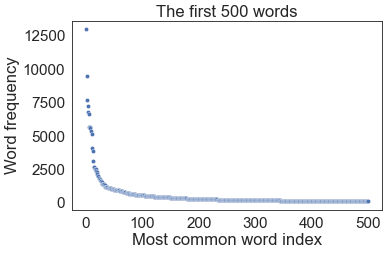

In [33]:
word_frequency = Counter(all_words)
word_frequency = word_frequency.most_common()
frequency_values = [x[1] for x in word_frequency]

fig, axes = plt.subplots(1, 1, figsize=(8, 5), dpi = 50)
sns.set(font_scale = 2)
sns.scatterplot(x = np.arange(0, len(word_frequency))[:500], y = frequency_values[:500], ax= axes)

plt.title('The first 500 words')
axes.set_xlabel('Most common word index')
axes.set_ylabel('Word frequency')
plt.show()

This fits the Zipf's law.   
$$f(k; s, N) = \frac{\frac{1}{k^s}}{\sum_{1}^{N}{\frac{1}{n^s}}}$$
where $k$ is the rank, $N$ is the number of elements, and $s$ is the parameter that characterizes the distribution.

### Question 2
Obviously, we're going to need a more rigorous way to find the distribution. First, find the maximum likelihood estimator for the parameter of the Zipf distribution. Zipf distribution only requires 1 parameter, *s*, the shape parameter.

### Answer 2

The probability mass function using Zipf distribution (from equation 1) can be used to calculate the log-likelihood $L(s)$.

$L(s) = Log(\frac{1}{k^s * HarmonicNumber(N, s)})$ 

Because of the Harmonic Numbers, it will be extremely difficult to find an analytical solution for the estimator. Therefore, we use optimization methods to find an estimate.

In [16]:
def neg_log_likelihood(s):
    N = sum(frequency_values)
    probs = np.log(frequency_values**(-1 * s) / np.sum(np.arange(1,  N+1)**(-1 * s)))
    summed = sum(probs * frequency_values)
    return -1 * summed

In [35]:
from scipy.optimize import minimize_scalar
from scipy.stats import zipf
frequency_values = np.array(frequency_values)
s_best = minimize_scalar(neg_log_likelihood, [0, 6.0] )
print(s_best.x)

1.0472055615708566


The best estimate for the $s$ parameter was 1.0472.

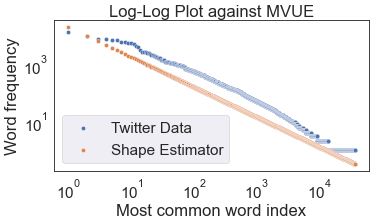

In [45]:
sns.set_style('white')
fig, axes = plt.subplots(1, 1, figsize=(8, 5), dpi = 50)
sns.set(font_scale = 2)
plt.yscale('log')
plt.xscale('log')
sns.scatterplot(x = np.arange(1, len(word_frequency)+1), y =frequency_values, ax= axes, label = 'Twitter Data')
plt.title('Log-Log Plot against MVUE')
axes.set_xlabel('Most common word index')
axes.set_ylabel('Word frequency')

# here, we are fitting the estimate we found using Scipy's built-in zipf PMF function.
fitted = np.array([zipf.pmf(n, s_best.x) for n in np.arange(1, len(frequency_values) + 1)]) * sum(frequency_values)

p1 = sns.scatterplot(x = np.arange(1, len(word_frequency) + 1), y = fitted, ax = axes, label = 'Shape Estimator')
p1.legend(frameon = True)
plt.tight_layout()
plt.show()

The estimate we found is a pretty good estimate to the 400,000 tweet data.

### Question 3
Using the MLE from question 2, bootstrap 10000 times and calculate this estimator 10000 times. What is the mean? the variance? Does this match with analytical solution?

Python's Scikit-Learn has a great bootstrap API that we will use. 

In [46]:
from sklearn.utils import resample

### Question 4
Using our hypothesis testing knowledge from class, determine if Donald Trump's tweets follow the distribution with the shape estimator from the bootstrap in question 3. You will need to set up a null/alternative hypotheses and a log-likelihood ratio statistic. Plot the p-values and the test statistic from the 10000 bootstraps.

### Question 5 
Now that we have a distribution that describes Donald Trump's "speaking" (writing) quality, **get the middle 30% of words in this distribution**. By doing so, we avoid very common words (called stop words) such as "the", "for", "and", but we also avoid words that are very rarely used and therefore do not represent the level of speaker well. Give us 10 words that fall in this section.

### Question 6
In natural langauge processing, a method to test the reading level of a writing is called the **Flesch Kincaid Grade Level Test**. Let's apply this test to the middle 30% of words that we've identified. Give a histogram of the results.

### Question 7
Calculate and present a 95% confidence interval of the grade results per tweet.

### Question 8
From the probability mass distribution in Question 2, calculate random sequences of words (creating our own sentences from the bank of Donald Trump words) using a **Metropolis-Hastings** algorithm. You must recreate this from scratch (no importing custom functions!). 